#### USER AUTOENCODER MODEL

In [21]:
PATH = '/home/g056122/DAFERS'
DATAPATH = '/home/g056122/ISG_studienarbeit/ml-1m'      

In [22]:
''' 
Load 'autoencoder' module from 'Module' folder
'''
# import required libraries
import pandas as pd
import numpy as np
import sklearn
import torch
import pickle
import matplotlib.pyplot as plt
from autoencoder import modeldata
from torch.utils.data import DataLoader
from torch import nn
import seaborn as sns
from scipy.special import expit

In [23]:
# load users data preparation file
[df, dftrain, dftest, df, dfratings, idx_to_user, idx_to_movie, movie_to_idx, user_to_idx]=pickle.load(open(f'{PATH}/1UsersData.pkl','rb'))

DATASET AND DATALOADER

In [24]:
# load dataset for the model
dstrain= modeldata(dftrain, dftest)

In [25]:
# create a DataLoader object
# batch size
bs=32
dltrain=DataLoader(dstrain,batch_size=bs,shuffle=True)
# print length
len(dltrain)

189

MODEL ARCHITECTURE

In [26]:
# model architecture
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout),
        nn.BatchNorm1d(y)
        )   

In [27]:
# create subclass for neural network module
class autoencoder (nn.Module):    
    def __init__(self, n_inp, hidden=[50,10], dropouts=[0,0,0], rating_range=[0.5,5]):
        # call parent class constructor in subclass using super function
        super().__init__()
        self.n_inp, self.hidden, self.dropouts, self.rating_range = n_inp, hidden, dropouts, rating_range
        # create hidden layer object list for encoder
        encoder=[hidden_layer(n_inp if i==0 else hidden[i-1],hidden[i],dropouts[i]) for i in range(len(hidden))]
        # unpack hidden layer objects in the sequential container
        self.encoder=nn.Sequential(*encoder)
        # reverse the order of elements in hidden list
        hidden=hidden[::-1]
        num_steps=len(hidden)-1
        dropouts=dropouts[num_steps:]
        # create hidden layer object list for decoder
        decoder=[hidden_layer(hidden[i],hidden[i+1] if i<num_steps else n_inp, dropouts[i]) for i in range(len(hidden)-1)]
        # unpack object list in the sequential 
        self.decoder=nn.Sequential(*decoder)
        # fully connected layer
        self.fc=nn.Linear(hidden[-1],n_inp)
        # initialize the weight and the bias values of the network's layers
        self.initialize()
        # define loss function for the model
        self.criterion=nn.MSELoss()
    
    # function to initialize the weights of layers for encoder and decoder
    def initialize(self):
        ''' 
        Function to initialize the weights for the layers
        '''
        for x in self.encoder:
            # initialize weight parameter using the Kaiming normal initialization
            nn.init.kaiming_normal_(x[0].weight.data)
        for x in self.decoder:
            nn.init.kaiming_normal_(x[0].weight.data)

    def forward (self, Xb):
        ''' 
        Function to perform forward pass
        
        Returns: test predictions, training loss, training predictions
        '''
        encoded=self.encoder(Xb)
        decoded=self.decoder(encoded)
        out=self.fc(decoded)
        # deep copy of predictions for the model
        outv=out.clone()
        # final output set to 0 if Xb is set 0
        out[Xb==0]=0
        # compute loss
        loss=self.criterion(out,Xb)
        # return original cloned output, loss and final output
        return outv, loss, out

LEARNER

In [28]:
class Learner():
    def __init__(self, model, optimizer, metric_fn, bptt = 12, print_every = 5, clip_val = \
            None, cycle_mult = 0, lr_decay = 0.7, wd_mult = 6, start_lr = 2e-2, end_lr = 5e-4):
        self.model, self.optimizer, self.metric_fn, self.print_every, self.bptt, self.losses, self.clip_val = \
            model, optimizer, metric_fn, print_every, bptt, [], clip_val
        self.n_epochs=1
        self.cycle_mult, self.lr_decay = cycle_mult, lr_decay
        self.wd_mult = wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds, self.preds_test, self.trainY, self.actual=[],[],[],[]
        self.ratio = self.end_lr/self.start_lr
        self.num_steps = self.cycle_mult
        self.reset_cycle = self.cycle_mult
        
    def fit (self,Xb,Xb_v,mode_train=True):
        ''' function to make predictions and losses for the model with given data

        Arguments:
            Xb: Training data
            Xb_v: Validation data

        Returns: train prediction, test prediction, train accuracy, test accuracy
        '''
        if mode_train:
            # set model to training mode
            self.model.train()
        else:
            # set model to evaluate mode
            self.model.eval()
        
        preds, loss, preds_train = self.model(Xb)

        mean_corrector = Xb.size(0)*Xb.size(1)/(torch.sum(Xb > 0).float() + 1e-10)
        mean_corrector_v = Xb_v.size(0)*Xb_v.size(1)/(torch.sum(Xb_v > 0).float() + 1e-10)
        # denominator is the average of the error with non-zero ratings

        with torch.no_grad():
            preds[Xb_v==0]=0
            loss_v=self.model.criterion(preds,Xb_v)
            # The value of the loss_v tensor can then be used to update the model's parameters and optimize its performance.
            
            if self.metric_fn is not None:
                # reshape the tensor Yb based on teh size of the other dimensions
                acc=self.metric_fn(preds,Yb.view(-1))
                # convert tensor scalar to python scalar
                acc=acc.item()

                if 1==0:
                    if mode_train:
                        self.trainY.append(Yb.view(-1))
                        self.preds.append(preds.data)
                    else:
                        self.actual.append(Yb.view(-1))
                        self.preds_valid.append(preds.data)
            else:
                acc = 0
                acc_v = 0
            del preds
        
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            # clear gradients of all optimized parameters. This method is typically called before computing the gradients of the model's parameters with backward() method
            self.optimizer.zero_grad()
            # compute gradients of loss with respect to paramters of neural network
            loss.backward()
            # optimizer updates the parameters
            self.optimizer.step()
        # compute train and test loss
        myloss=torch.sqrt(loss.item()*mean_corrector)
        myloss_v=torch.sqrt(loss_v.item()*mean_corrector_v)
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc, myloss_v,acc_v
    
    def lr_find (self, start_lr, end_lr, iterator, n_batch):
        ''' 
        Function to determine optimal learning rate for training the model
        '''
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):   
            # learning rate schedule to gradually decrease the learning rate over time         
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        ''' 
        Function to train the model for one epoch
        '''
        epoch_loss, epoch_acc, i, k=0, 0, 0, 0
        epoch_loss_v, epoch_acc_v = 0, 0

        for Xb, Xb_v in iterator:
            Xb = Xb
            Xb_v = Xb_v
            if lrs is not None:
                lr = lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            
            loss, acc, loss_v, acc_v = self.fit (Xb, Xb_v, mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            epoch_loss+=loss
            epoch_acc+=acc
            epoch_loss_v+=loss_v
            epoch_acc_v+=acc_v
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} Train loss: {epoch_loss/(k)} Test loss: {epoch_loss_v/(k)} ')  
        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_loss_v=epoch_loss_v/len(iterator)
        epoch_acc_v=epoch_acc_v/len(iterator)
            
        return epoch_loss, epoch_acc, epoch_loss_v, epoch_acc_v
    
    def plot_lrs(self, n_roll = 1, ylim = None, xlim = None):
        ''' 
        Function to plot graph of learning rate vs loss
        '''
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):
        ''' 
        Function to run epochs for n times
        '''
        for epoch in range(n_epochs):                

            loss, acc, lossv, accv = self.run_epoch(dltrain,True)
            print (f'Epoch:{epoch+1} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss}  Test Loss:{lossv} ')
  
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    self.reset_cycle*=self.cycle_mult
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1

            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr         

In [29]:
# model architecture object
autoencoderobj = autoencoder(dftrain.shape[1],[100,25],[0.2,0.2,0.2])
#optimizer
optimizer=torch.optim.Adam(autoencoderobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=1e-7)
# learner object
learner=Learner(autoencoderobj, optimizer,None,0,500,0.25,cycle_mult=0)

In [30]:
# find optimal learning rate 
learner.lr_find(1e-4,3e-1,dltrain,len(dltrain))

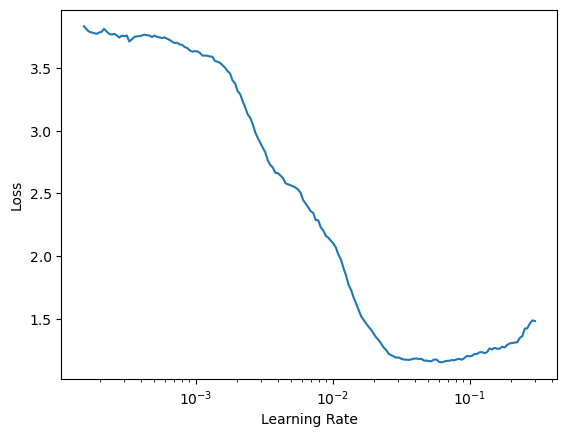

In [31]:
# plot for learning rate schedule
learner.plot_lrs(10)

In [32]:
learner.run_epochs(dltrain,None,5)

Epoch:1 Learning rate 0.005 Weight Decay 1e-07 Train Loss:1.2770363092422485  Test Loss:1.2765843868255615 
Epoch:2 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9974448680877686  Test Loss:0.9975978136062622 
Epoch:3 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9798130393028259  Test Loss:0.9798939228057861 
Epoch:4 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9781323075294495  Test Loss:0.9781518578529358 
Epoch:5 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.9775764346122742  Test Loss:0.9776224493980408 


SAVE

In [33]:
# save model archeitecture, classes and functions
torch.save(autoencoderobj,f=f'{PATH}/2UserAutoencoder')
torch.save(learner,f=f'{PATH}/2UserAutoencoderLearner')
torch.save(optimizer,f=f'{PATH}/2UserAutoencoderOptimizer')
# dictionary containing all the information required to recreate a model archeitecture and state i.e. parameters and buffers of the model.
torch.save(autoencoderobj.state_dict(),f'{PATH}/2UserAutoencoderStateDict')
torch.save(optimizer.state_dict(),f'{PATH}/2UserAutoencoderOptimizerStateDict')

DATA PREPARATION FOR USER AUTOENCODER LATENT FEATURES

In [34]:
# convert encoder layer weights to a numpy array
user_mtx_1_weights=autoencoderobj.encoder[0][0].weight.data.numpy()
user_mtx_2_weights=autoencoderobj.encoder[1][0].weight.data.numpy()

In [35]:
# Matrix multiplication
# expit function squashes the input value between 0 and 1
dftrain_userauto=(expit(dftrain@user_mtx_1_weights.T)@user_mtx_2_weights.T)
dftest_userauto=(expit(dftest@user_mtx_1_weights.T)@user_mtx_2_weights.T)
dftrain_userauto_linear=((dftrain@user_mtx_1_weights.T)@user_mtx_2_weights.T)
dftest_userauto_linear=((dftest@user_mtx_1_weights.T)@user_mtx_2_weights.T)

In [36]:
# create training arrays to pandas dataframe
dftrain_userauto=pd.DataFrame(dftrain_userauto)
dftrain_userauto_linear=pd.DataFrame(dftrain_userauto_linear)
# create test arrays to pandas dataframe
dftest_userauto=pd.DataFrame(dftest_userauto)
dftest_userauto_linear=pd.DataFrame(dftest_userauto_linear)

In [37]:
# define columns for training dataframe
dftrain_userauto.columns=['user_autoenc'+str(i) for i in range(dftrain_userauto.shape[1])]
dftrain_userauto_linear.columns=['user_autoenc_linear'+str(i) for i in range(dftrain_userauto_linear.shape[1])]
# define columns for test dataframe
dftest_userauto.columns=['user_autoenc'+str(i) for i in range(dftest_userauto.shape[1])]
dftest_userauto_linear.columns=['user_autoenc_linear'+str(i) for i in range(dftest_userauto_linear.shape[1])]

In [38]:
# reset indices of dataframes
dftrain_userauto.reset_index(inplace=True)
dftest_userauto.reset_index(inplace=True)

In [39]:
# rename index
dftrain_userauto.rename({'index':'user_idx'},axis=1,inplace=True)
dftest_userauto.rename({'index':'user_idx'},axis=1,inplace=True)

In [40]:
# save item latent features to pickle file
pickle.dump([dftrain_userauto,dftest_userauto,user_mtx_1_weights,user_mtx_2_weights,dftrain_userauto_linear,dftest_userauto_linear],open(f'{PATH}/2UserAutoencoderWeights.pkl','wb'))